# Analyzing NYC's 311 Street Flooding Complaints from 2010 to 2020
## Timeseries Analysis

Mark Bauer

# Goal
In this notebook, we perform basic timeseries analysis with NYC's 311 Street Flooding Complaints data from 2010 to 2020. Specifically, I attempt to inspect the following questions:

- How have street flooding complaints changed over time city-wide and by borough?
- Is there any seasonality?
- Are there any overall trends?

# Main Python Libraries:
[pandas](https://pandas.pydata.org/) is a fast, powerful, flexible and easy to use open source data analysis and manipulation tool, built on top of the Python programming language.

[GeoPandas](https://geopandas.org/index.html) is an open source project to make working with geospatial data in python easier. GeoPandas extends the datatypes used by pandas to allow spatial operations on geometric types. Geometric operations are performed by shapely. Geopandas further depends on fiona for file access and descartes and matplotlib for plotting.

[Matplotlib](https://matplotlib.org/3.1.1/index.html#) is a Python 2D plotting library which produces publication quality figures in a variety of hardcopy formats and interactive environments across platforms.

[Seaborn](https://seaborn.pydata.org/index.html) is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics.

[geoplot](https://residentmario.github.io/geoplot/index.html#) is a high-level Python geospatial plotting library. It’s an extension to cartopy and matplotlib which makes mapping easy: like seaborn for geospatial.

[fiona](https://github.com/Toblerity/Fiona) is a geospatial library that reads and writes geographical data files.

# Datasets

## 311 Service Requests from 2010 to Present  
Website: https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9

311's data dictionary can be found in the data folder. 



![311](images/nyc-311-screenshot.png)

## Neighborhood Tabulation Areas (NTA)  
Website: https://data.cityofnewyork.us/City-Government/Neighborhood-Tabulation-Areas-NTA-/cpf4-rkhq

![nta](images/nyc-nta-screenshot.png)

Table of Contents
=================

   * [1. Importing Libraries](#1-Importing-Libraries)
       
       
   * [2. Loading Data](#2-Loading-Data)
       
       
   * [3. Data Inspection](#3-Data-Inspection)
       * [3.1 Basic Data Inspection](#31-Basic-Data-Inspection)
       * [3.2 Calculating Summary Statistics](#32-Calculating-Summary-Statistics)
       * [3.3 Identifying Null/NA Values](#33-Identifying-Null/NA-Values)
   
   
   * [4. Data Wrangling](#4-Data-Wrangling)
       * [4.1 Converting date column to Python's datetime64[ns] data type](#41-Converting-date-column-to-Pythons-datetime64[ns]-data-type)
       * [4.2 Dropping null values in our x, y coordinate columns](#42-Dropping-null-values-in-our-x-y-coordinate-columns)
       * [4.3 Creating a GeoDataframe from x,y coordinates](#43-Creating-a-GeoDataframe-from-x-y-coordinates)
       

   * [5. Mapping](#5-Mapping)
       * [5.1 Citywide](#51-Citywide)
       * [5.2 By Borough](#52-By-Borough)
       * [5.3 Bar Charts by Neighborhood Tabulation Areas (NTA)](#53-Bar-Charts-by-Neighborhood-Tabulation-Areas-(NTA))

      
   * [6. Time Series Analysis](#6-Time-Series-Analysis)
       * [6.1 By Year and Borough](#61-By-Year-and-Borough)
       * [6.2 Frequencies](#62-Frequencies)
       * [6.3 Resampling](#63-Resampling)
       * [6.4 Seasonality](#64-Seasonality)
       * [6.5 Resampling for Frequency Average](#65-Resampling-for-Frequency-Average)
       * [6.6 Rolling Averages](66-Rolling-Averages)
       * [6.7 Additional Time Series Analysis](#67-Additional-Time-Series-Analysis)
   
          
   * [7. Anomoly Detection](#7-Anomoly-Detection)
   
          
   * [8. Manually Formatting Date Tick Labels](#8-Manually-Formatting-Date-Tick-Labels)
   
   
   * [9. Timedelta of Complaints](#9-Timedelta-of-Complaints)
   
          
   * [10. Conclusion](#10-Conclusion)

# 1. Importing Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
import fiona
from fiona.crs import from_epsg
import geoplot
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import datetime

plt.rcParams['savefig.facecolor'] = 'white'
%matplotlib inline

Printing versions of Python modules and packages with **watermark** - the IPython magic extension.

In [2]:
%load_ext watermark

In [3]:
%watermark -v -p numpy,pandas,geopandas,geoplot,fiona,matplotlib.pyplot,seaborn

Python implementation: CPython
Python version       : 3.8.13
IPython version      : 8.4.0

numpy            : 1.23.1
pandas           : 1.4.3
geopandas        : 0.11.1
geoplot          : 0.5.1
fiona            : 1.8.21
matplotlib.pyplot: unknown
seaborn          : 0.11.2



Documention for installing watermark: https://github.com/rasbt/watermark

# 2. Loading Data

In [4]:
# list items in data folder
%ls data/

README.md                       street-flooding-complaints.csv
data-dictionaries/              streets-clipped.json


In [5]:
# read data as a dataframe
df = pd.read_csv('data/street-flooding-complaints.csv', low_memory=False)

print('shape of data: {}'.format(df.shape))
print('unique key is unique: {}'.format(df['unique_key'].is_unique))

df.head()

shape of data: (27902, 34)
unique key is unique: True


,unique_key,created_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,cross_street_1,...,location,intersection_street_1,intersection_street_2,closed_date,resolution_description,resolution_action_updated_date,location_type,landmark,facility_type,due_date
0,48542220,2020-12-31T15:41:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11420.0,117-17 135 STREET,135 STREET,FOCH BLVD,...,"{'latitude': '40.67703755925495', 'longitude':...",NaN,NaN,2021-01-01T00:20:00.000,Please call 311 for further information. If yo...,2021-01-01T00:20:00.000,NaN,NaN,NaN,NaN
1,48536430,2020-12-31T14:49:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11357.0,20-24 150 STREET,150 STREET,20 AVE,...,"{'latitude': '40.78072630540092', 'longitude':...",NaN,NaN,2021-01-04T10:15:00.000,The Department of Environment Protection inspe...,2021-01-04T10:15:00.000,NaN,NaN,NaN,NaN
2,48539361,2020-12-31T14:03:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11228.0,7223 8 AVENUE,8 AVENUE,72 ST,...,"{'latitude': '40.62849640806448', 'longitude':...",NaN,NaN,2021-01-02T11:25:00.000,The Department of Environmental Protection has...,2021-01-02T11:25:00.000,NaN,NaN,NaN,NaN
3,48543132,2020-12-31T13:48:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10032.0,NaN,NaN,NaN,...,"{'latitude': '40.841051689545516', 'longitude'...",RIVERSIDE DRIVE,WEST 165 STREET,2020-12-31T14:50:00.000,Please call 311 for further information. If yo...,2020-12-31T14:50:00.000,NaN,NaN,NaN,NaN
4,48536441,2020-12-31T13:10:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11234.0,3123 FILLMORE AVENUE,FILLMORE AVENUE,E 31 ST,...,"{'latitude': '40.609203447399906', 'longitude'...",NaN,NaN,2021-01-03T10:45:00.000,The Department of Environmental Protection ins...,2021-01-03T10:45:00.000,NaN,NaN,NaN,NaN


In [6]:
# printing the column names, non-null counts, and data types of our columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27902 entries, 0 to 27901
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   unique_key                      27902 non-null  int64  
 1   created_date                    27902 non-null  object 
 2   agency                          27902 non-null  object 
 3   agency_name                     27902 non-null  object 
 4   complaint_type                  27902 non-null  object 
 5   descriptor                      27902 non-null  object 
 6   incident_zip                    27045 non-null  float64
 7   incident_address                17865 non-null  object 
 8   street_name                     17865 non-null  object 
 9   cross_street_1                  24148 non-null  object 
 10  cross_street_2                  24137 non-null  object 
 11  address_type                    27896 non-null  object 
 12  city                            

In [7]:
# printing the columns of our dataframe
df.columns

Index(['unique_key', 'created_date', 'agency', 'agency_name', 'complaint_type',
       'descriptor', 'incident_zip', 'incident_address', 'street_name',
       'cross_street_1', 'cross_street_2', 'address_type', 'city', 'status',
       'community_board', 'bbl', 'borough', 'x_coordinate_state_plane',
       'y_coordinate_state_plane', 'open_data_channel_type',
       'park_facility_name', 'park_borough', 'latitude', 'longitude',
       'location', 'intersection_street_1', 'intersection_street_2',
       'closed_date', 'resolution_description',
       'resolution_action_updated_date', 'location_type', 'landmark',
       'facility_type', 'due_date'],
      dtype='object')

In [8]:
df = df[['unique_key', 'created_date', 'agency', 'agency_name', 'complaint_type',
       'descriptor', 'incident_zip', 'incident_address', 'street_name',
       'cross_street_1', 'cross_street_2', 'address_type', 'city', 'status',
       'community_board', 'bbl', 'borough', 'x_coordinate_state_plane',
       'y_coordinate_state_plane', 'open_data_channel_type',
       'park_facility_name', 'park_borough', 'latitude', 'longitude',
       'location', 'intersection_street_1', 'intersection_street_2',
       'closed_date', 'resolution_description',
       'resolution_action_updated_date']]

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27902 entries, 0 to 27901
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   unique_key                      27902 non-null  int64  
 1   created_date                    27902 non-null  object 
 2   agency                          27902 non-null  object 
 3   agency_name                     27902 non-null  object 
 4   complaint_type                  27902 non-null  object 
 5   descriptor                      27902 non-null  object 
 6   incident_zip                    27045 non-null  float64
 7   incident_address                17865 non-null  object 
 8   street_name                     17865 non-null  object 
 9   cross_street_1                  24148 non-null  object 
 10  cross_street_2                  24137 non-null  object 
 11  address_type                    27896 non-null  object 
 12  city                            

In [9]:
(print('This dataset is from {} to {}'
    .format(df.created_date.min()[0:10],
            df.created_date.max()[0:10]))
)

This dataset is from 2010-01-02 to 2020-12-31


## 3.2 Calcualting Summary Statistics

In [10]:
# printing descriptive statistics of our numeric columns in our data
df.describe()

,unique_key,incident_zip,bbl,x_coordinate_state_plane,y_coordinate_state_plane,latitude,longitude
count,2.790200e+04,27045.000000,1.615900e+04,2.695900e+04,26959.000000,26959.000000,26959.000000
mean,3.243189e+07,10969.151488,3.699429e+09,1.005498e+06,186184.607441,40.677615,-73.923323
std,9.183919e+06,536.262125,1.075864e+09,3.505257e+04,30576.150750,0.083924,0.126329
min,1.563993e+07,10001.000000,0.000000e+00,9.133570e+05,121032.000000,40.498628,-74.254937
25%,2.429024e+07,10312.000000,3.060255e+09,9.868870e+05,161248.000000,40.609123,-73.990504
50%,3.276295e+07,11220.000000,4.067910e+09,1.007480e+06,183618.000000,40.670610,-73.916267
75%,4.039421e+07,11385.000000,4.156250e+09,1.033980e+06,206488.500000,40.733373,-73.820554
max,4.854313e+07,11697.000000,5.080500e+09,1.067279e+06,271876.000000,40.912869,-73.700384


In [11]:
df.describe(include=['O']).T

,count,unique,top,freq
created_date,27902,26389,2011-08-28T00:00:00.000,13
agency,27902,1,DEP,27902
agency_name,27902,1,Department of Environmental Protection,27902
complaint_type,27902,1,Sewer,27902
descriptor,27902,1,Street Flooding (SJ),27902
incident_address,17865,12445,133-25 FRANCIS LEWIS BOULEVARD,59
street_name,17865,4108,BROADWAY,116
cross_street_1,24148,4621,BEND,342
cross_street_2,24137,4698,DEAD END,492
address_type,27896,4,ADDRESS,16733


## 3.3 Identifying Null/NA Values

In [12]:
print('% NULL')

(df
 .isnull()
 .sum()
 .sort_values(ascending=False) \
 / len(df) * 100
).round(2)

% NULL


intersection_street_1             63.83
intersection_street_2             63.83
bbl                               42.09
street_name                       35.97
incident_address                  35.97
cross_street_2                    13.49
cross_street_1                    13.45
location                           3.38
longitude                          3.38
x_coordinate_state_plane           3.38
y_coordinate_state_plane           3.38
latitude                           3.38
incident_zip                       3.07
city                               3.06
resolution_description             0.02
address_type                       0.02
closed_date                        0.01
park_borough                       0.01
community_board                    0.01
borough                            0.01
unique_key                         0.00
park_facility_name                 0.00
open_data_channel_type             0.00
created_date                       0.00
status                             0.00


In [13]:
(print('Total nulls in all columns: {:,}'
    .format(
        df
        .isnull()
        .sum()
        .sum()))
)

Total nulls in all columns: 81,404


# 4. Data Wrangling

## 4.1 Converting date column to Python's datetime64[ns] data type

In [14]:
print('create_date dtype: {}'.format(df['created_date'].dtype))
df['created_date'] = pd.to_datetime(df['created_date'])
print('new create_date dtype: {}'.format(df['created_date'].dtype))

(df[['created_date']]
.describe(datetime_is_numeric=True)
)

create_date dtype: object
new create_date dtype: datetime64[ns]


,created_date
count,27902
mean,2015-10-23 19:30:37.610207232
min,2010-01-02 08:26:00
25%,2012-10-29 22:57:45
50%,2016-02-24 13:08:00
75%,2018-09-27 13:30:00
max,2020-12-31 15:41:00


<AxesSubplot:>

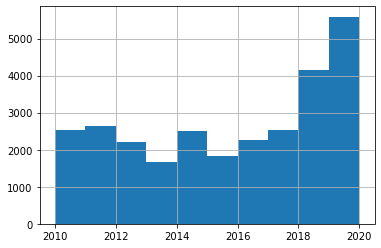

In [15]:
df['year'] = df['created_date'].dt.year

df['year'].hist()

# 6. Time Series Analysis

## 6.1 By Year and Borough

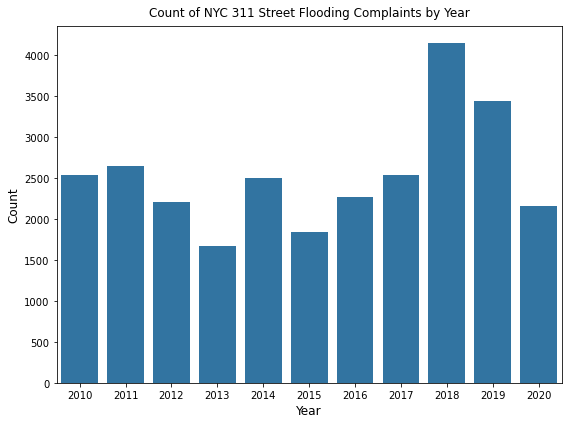

In [16]:
plt.figure(figsize=(8, 6))

sns.countplot(x=df['year'], color='#1f77b4')

plt.title('Count of NYC 311 Street Flooding \
Complaints by Year', fontsize=12, pad=10)

plt.xlabel('Year', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout()

In [17]:
df['borough'].value_counts()

QUEENS           11039
BROOKLYN          7122
STATEN ISLAND     5022
MANHATTAN         2618
BRONX             2087
Unspecified         12
Name: borough, dtype: int64

In [18]:
df = (
    df
    .loc[df.borough != 'Unspecified']
    .reset_index(drop=True)
)

df['borough'].value_counts()

QUEENS           11039
BROOKLYN          7122
STATEN ISLAND     5022
MANHATTAN         2618
BRONX             2087
Name: borough, dtype: int64

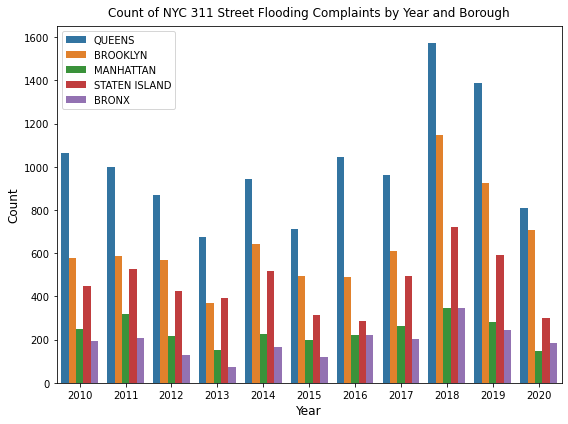

In [19]:
plt.figure(figsize=(8,6))

sns.countplot(data=df,
              x="year", 
              hue='borough')

plt.title('Count of NYC 311 Street Flooding Complaints by Year and Borough', 
          fontsize=12,
          pad=10)

plt.xlabel('Year', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(loc=2, fontsize=10)
plt.tight_layout()

In [20]:
pivot_df = (
    pd.pivot_table(
        df,
        values='unique_key',
        index=['year'],
        columns=['borough'],
        aggfunc=pd.Series.nunique)
    .rename({'unique_key': 'count'}, axis=1)
)

pivot_df.head()

borough,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND
year,,,,,
2010,193,576,248,1064,450
2011,208,589,317,1000,527
2012,128,568,215,869,423
2013,72,370,152,676,394
2014,166,644,225,944,519


In [21]:
# order items in legend consistent to above plot
pivot_df = pivot_df[['QUEENS', 'BROOKLYN', 'MANHATTAN', 'STATEN ISLAND', 'BRONX']]

pivot_df.head()

borough,QUEENS,BROOKLYN,MANHATTAN,STATEN ISLAND,BRONX
year,,,,,
2010,1064,576,248,450,193
2011,1000,589,317,527,208
2012,869,568,215,423,128
2013,676,370,152,394,72
2014,944,644,225,519,166


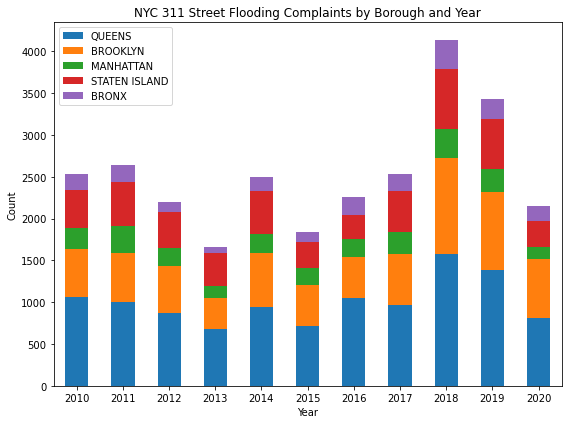

In [22]:
fig, ax = plt.subplots(figsize=(8,6))

pivot_df.plot.bar(stacked=True, ax=ax)

plt.legend(loc=2, fontsize=10)
plt.xticks(rotation=0)

plt.ylabel('Count')
plt.xlabel('Year')
plt.title('NYC 311 Street Flooding Complaints by Borough and Year', fontsize=12)

plt.tight_layout()

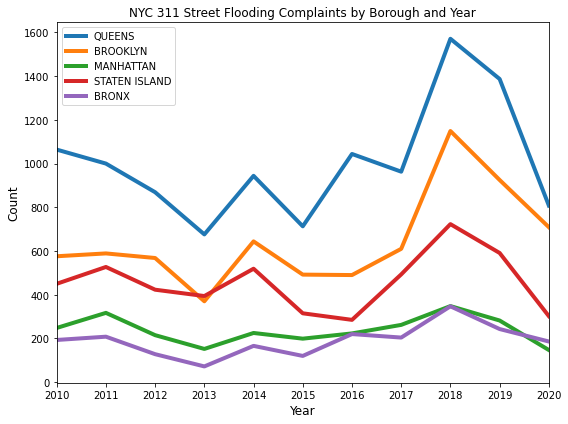

In [23]:
fig, ax = plt.subplots(figsize=(8,6))

ax.xaxis.set_major_locator(plt.MultipleLocator(1))

pivot_df.plot.line(ax=ax, linewidth=4)

plt.legend(loc=2, fontsize=10)
plt.xticks(rotation=0)
plt.xlim(2010, 2020)

plt.ylabel('Count', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.title('NYC 311 Street Flooding Complaints by Borough and Year', fontsize=12)
plt.tight_layout()

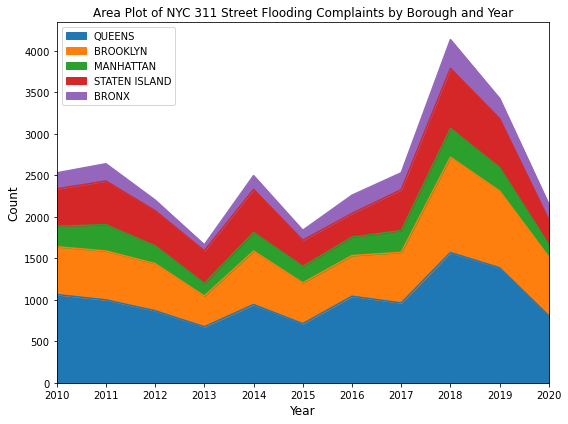

In [24]:
fig, ax = plt.subplots(figsize=(8,6))

ax.xaxis.set_major_locator(plt.MultipleLocator(1))

pivot_df.plot.area(ax=ax)

plt.legend(loc=2, fontsize=10)
plt.xlim(2010, 2020)

plt.ylabel('Count', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.title('Area Plot of NYC 311 Street Flooding Complaints by Borough and Year', fontsize=12)
plt.tight_layout()

In [25]:
pivot_table_cumsum = pivot_df.cumsum()
pivot_table_cumsum.head()

borough,QUEENS,BROOKLYN,MANHATTAN,STATEN ISLAND,BRONX
year,,,,,
2010,1064,576,248,450,193
2011,2064,1165,565,977,401
2012,2933,1733,780,1400,529
2013,3609,2103,932,1794,601
2014,4553,2747,1157,2313,767


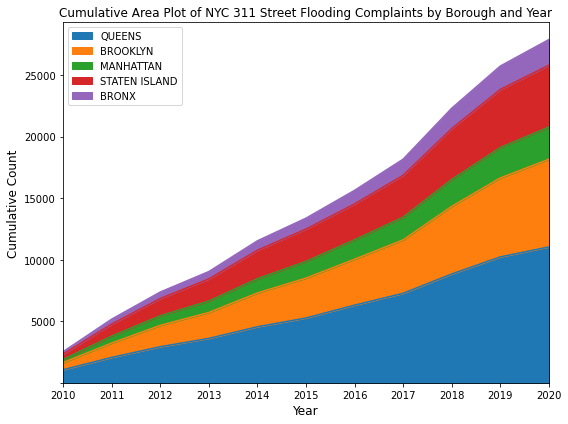

In [26]:
fig, ax = plt.subplots(figsize=(8,6))

ax.xaxis.set_major_locator(plt.MultipleLocator(1))

pivot_table_cumsum.plot.area(ax=ax)

plt.legend(loc=2, fontsize=10)
plt.xticks(rotation=0)
plt.xlim(2010, 2020)
plt.setp(ax.get_yticklabels()[0], visible=False)

plt.ylabel('Cumulative Count', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.title('Cumulative Area Plot of NYC 311 Street Flooding Complaints by Borough and Year', fontsize=12)

plt.tight_layout()

In [27]:
data_perc = round(
    pivot_df
    .divide(pivot_df.sum(axis=0), axis=1) * 100, 2)

data_perc.head(len(data_perc))

borough,QUEENS,BROOKLYN,MANHATTAN,STATEN ISLAND,BRONX
year,,,,,
2010,9.64,8.09,9.47,8.96,9.25
2011,9.06,8.27,12.11,10.49,9.97
2012,7.87,7.98,8.21,8.42,6.13
2013,6.12,5.20,5.81,7.85,3.45
2014,8.55,9.04,8.59,10.33,7.95
2015,6.46,6.91,7.60,6.27,5.75
2016,9.46,6.88,8.52,5.68,10.54
2017,8.72,8.57,10.01,9.82,9.77
2018,14.23,16.13,13.29,14.40,16.63


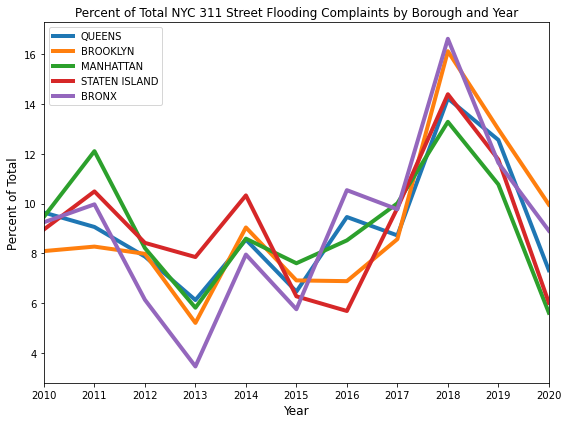

In [28]:
fig, ax = plt.subplots(figsize=(8,6))

ax.xaxis.set_major_locator(plt.MultipleLocator(1))

data_perc.plot(ax=ax, linewidth=4)

plt.xticks(rotation=0)
plt.legend(loc=2, fontsize=10)
plt.xlim(2010, 2020)

plt.ylabel('Percent of Total', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.title('Percent of Total NYC 311 Street Flooding Complaints by Borough and Year', fontsize=12)

plt.tight_layout()

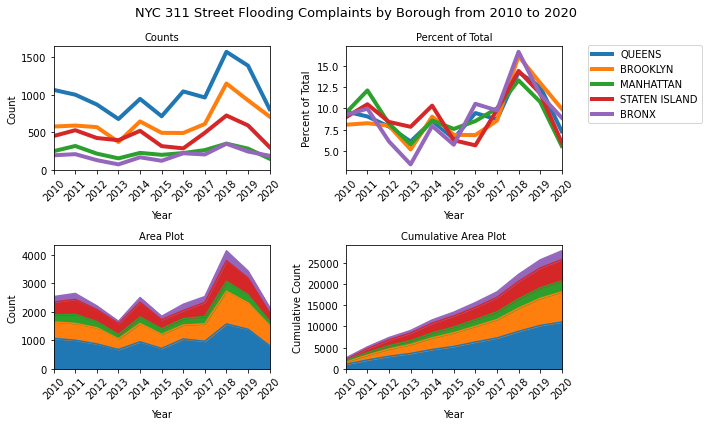

In [29]:
fig, axs = plt.subplots(2, 2, sharey=False, figsize=(10,6))

pivot_df.plot.line(linewidth=4, ax=axs[0,0])
axs[0,0].xaxis.set_major_locator(plt.MultipleLocator(1))
axs[0,0].set_ylabel('Count', fontsize=10)
axs[0,0].set_title('Counts', fontsize=10)

data_perc.plot(ax=axs[0,1], linewidth=4)
axs[0,1].xaxis.set_major_locator(plt.MultipleLocator(1))
axs[0,1].tick_params(labelrotation=0)
axs[0,1].legend(loc=2, title='borough')
axs[0,1].set_ylabel('Percent of Total', fontsize=10)
axs[0,1].set_title('Percent of Total', fontsize=10)

pivot_df.plot.area(ax=axs[1,0])
axs[1,0].xaxis.set_major_locator(plt.MultipleLocator(1))
axs[1,0].set_ylabel('Count', fontsize=10)
axs[1,0].set_title('Area Plot', fontsize=10)
    
pivot_table_cumsum.plot.area(ax=axs[1,1])
axs[1,1].xaxis.set_major_locator(plt.MultipleLocator(1))
axs[1,1].set_ylabel('Cumulative Count', fontsize=10)
axs[1,1].set_title('Cumulative Area Plot', fontsize=10)

for ax in axs.flat:
    ax.set_xlabel('Year', fontsize=10, labelpad=8) 
    ax.get_legend().remove()
    ax.tick_params(axis='x', labelrotation=45)
    ax.set_xlim(2010, 2020)
axs[0,1].legend(bbox_to_anchor=(1.1, 1.05))    

fig.suptitle('NYC 311 Street Flooding Complaints by Borough from 2010 to 2020', fontsize=13) 
fig.tight_layout()

## 6.2 Frequencies

In [30]:
# extract date time information
df['year_month_day'] = df['created_date'].dt.strftime('%Y-%m-%d')
df['year_month'] = df['created_date'].dt.strftime('%Y-%m')
df['year_month_week'] = df['created_date'].dt.strftime('%Y-%W')

df['year_month_day'] = pd.to_datetime(df['year_month_day'])
df['year_month'] = pd.to_datetime(df['year_month'])
df['year_month_week'] = pd.to_datetime(df['year_month_week'] + '0', format='%Y-%W%w')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27890 entries, 0 to 27889
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   unique_key                      27890 non-null  int64         
 1   created_date                    27890 non-null  datetime64[ns]
 2   agency                          27890 non-null  object        
 3   agency_name                     27890 non-null  object        
 4   complaint_type                  27890 non-null  object        
 5   descriptor                      27890 non-null  object        
 6   incident_zip                    27038 non-null  float64       
 7   incident_address                17862 non-null  object        
 8   street_name                     17862 non-null  object        
 9   cross_street_1                  24143 non-null  object        
 10  cross_street_2                  24132 non-null  object        
 11  ad

In [31]:
flooding_311_daily = (
    df
    .groupby(by='year_month_day')['unique_key']
    .count()
    .asfreq('D')
    .rename(index="count")
    .fillna(0)
    .astype(int)
)

flooding_311_daily

year_month_day
2010-01-02     3
2010-01-03     0
2010-01-04     1
2010-01-05     1
2010-01-06     4
              ..
2020-12-27     4
2020-12-28     4
2020-12-29     7
2020-12-30     2
2020-12-31    17
Freq: D, Name: count, Length: 4017, dtype: int64

In [32]:
zero_days = len(flooding_311_daily.loc[flooding_311_daily < 1])
print('number of days without flooding complaints: {}'
      .format(zero_days))

number of days without flooding complaints: 543


In [33]:
flooding_311_daily.describe()

count    4017.000000
mean        6.942992
std        14.995417
min         0.000000
25%         1.000000
50%         3.000000
75%         6.000000
max       247.000000
Name: count, dtype: float64

Text(0.5, 1.0, 'Distribution of 311 Street Flooding Complaints per Day')

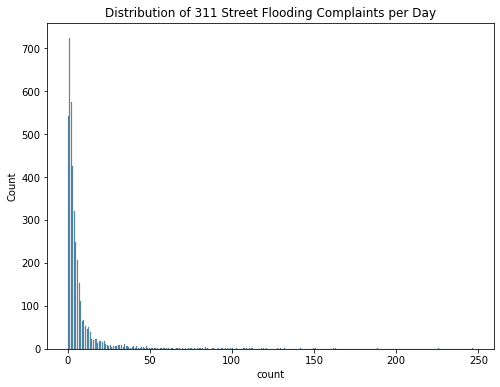

In [34]:
plt.figure(figsize=(8, 6))

sns.histplot(flooding_311_daily)
plt.title('Distribution of 311 Street Flooding Complaints per Day')

Text(0.5, 1.0, 'Distribution of 311 Street Flooding Complaints per Day (Excluding Zeros)')

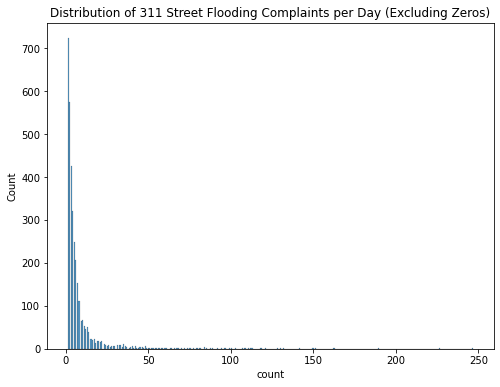

In [35]:
plt.figure(figsize=(8, 6))

sns.histplot(flooding_311_daily.loc[flooding_311_daily > 0])
plt.title('Distribution of 311 Street Flooding Complaints per Day \
(Excluding Zeros)')

In [36]:
flooding_311_daily.sort_values(ascending=False).head(20)

year_month_day
2017-05-05    247
2014-12-09    226
2014-04-30    189
2018-04-16    163
2013-05-08    162
2016-11-15    151
2016-02-08    150
2018-11-25    142
2020-07-10    132
2010-10-01    130
2010-03-30    128
2014-05-01    121
2014-11-17    119
2018-03-02    119
2012-05-21    118
2020-11-30    113
2018-11-26    112
2010-12-01    111
2011-02-02    109
2019-07-23    108
Name: count, dtype: int64

## 6.3 Resampling

A better way to extract different frequencies is to resample data based on daily observations. This is how I'll plot the subsequent figures.

In [37]:
flooding_311_daily = (
    df
    .groupby(by='year_month_day')['unique_key']
    .count()
    .resample('D')
    .sum()
    .rename(index="count")
)

flooding_311_daily

year_month_day
2010-01-02     3
2010-01-03     0
2010-01-04     1
2010-01-05     1
2010-01-06     4
              ..
2020-12-27     4
2020-12-28     4
2020-12-29     7
2020-12-30     2
2020-12-31    17
Freq: D, Name: count, Length: 4017, dtype: int64

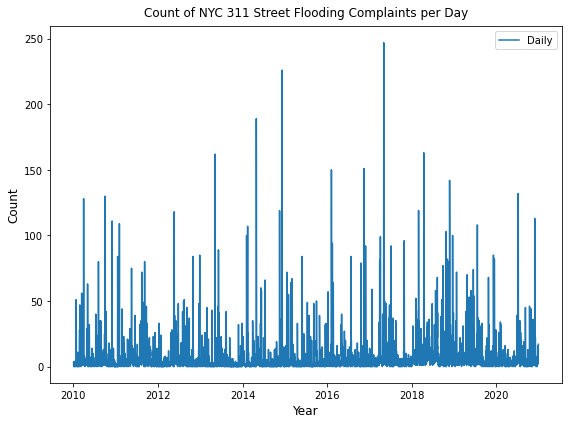

In [38]:
plt.figure(figsize=(8, 6))

sns.lineplot(data=flooding_311_daily, label='Daily')

plt.title('Count of NYC 311 Street Flooding Complaints per Day', 
          fontsize=12,
          pad=10)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout()

In [39]:
print('daily')
print(flooding_311_daily.resample('D').sum().reset_index().head())

print('weekly')
print(flooding_311_daily.resample('W').sum().reset_index().head())

print('monthly')
print(flooding_311_daily.resample('MS').sum().reset_index().head())

print('yearly')
print(flooding_311_daily.resample('YS').sum().reset_index().head())

daily
  year_month_day  count
0     2010-01-02      3
1     2010-01-03      0
2     2010-01-04      1
3     2010-01-05      1
4     2010-01-06      4
weekly
  year_month_day  count
0     2010-01-03      3
1     2010-01-10     11
2     2010-01-17      8
3     2010-01-24     13
4     2010-01-31     73
monthly
  year_month_day  count
0     2010-01-01    108
1     2010-02-01    187
2     2010-03-01    489
3     2010-04-01    149
4     2010-05-01    203
yearly
  year_month_day  count
0     2010-01-01   2531
1     2011-01-01   2641
2     2012-01-01   2203
3     2013-01-01   1664
4     2014-01-01   2498


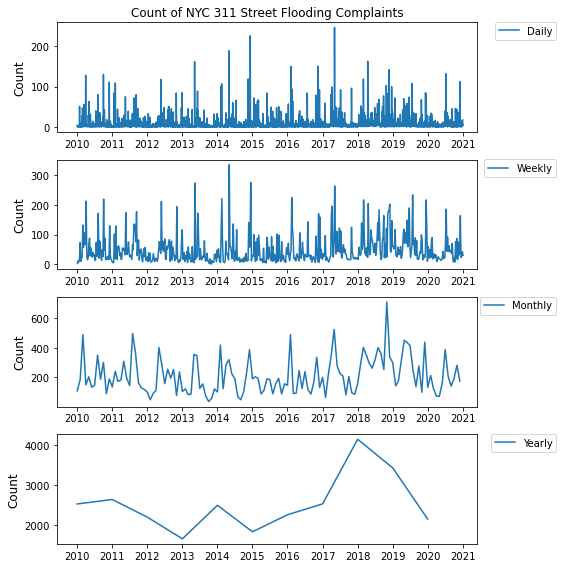

In [40]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharey=False, figsize=(8, 8))

years = mdates.YearLocator()  # every year

sns.lineplot(data=flooding_311_daily.resample('D').sum(), 
             label='Daily', 
             ax=ax1)
sns.lineplot(data=flooding_311_daily.resample('W').sum(), 
             label='Weekly', 
             ax=ax2)

sns.lineplot(data=flooding_311_daily.resample('MS').sum(), 
             label='Monthly', 
             ax=ax3)

sns.lineplot(data=flooding_311_daily.resample('YS').sum(), 
             label='Yearly', 
             ax=ax4) 

ax1.set_title('Count of NYC 311 Street Flooding Complaints', fontsize=12)

lst = [ax1, ax2, ax3, ax4]
for i in range(len(lst)):
    lst[i].set_ylabel('Count', fontsize=12) 
    lst[i].set_xlabel('', fontsize=12)
    lst[i].legend(loc=2, fontsize=12)
    lst[i].legend(bbox_to_anchor=(1.2, 1.05)) 
    lst[i].xaxis.set_major_locator(years)  
    lst[i].set_xlim([datetime.date(2009, 6, 1), datetime.date(2021, 6, 1)]) 

plt.tight_layout()
plt.savefig('figures/timeseries_10.png', bbox_inches='tight')

## 6.4 Seasonality

In [41]:
df['month'] = df['created_date'].dt.month

df.iloc[:, -5:].head()

,year,year_month_day,year_month,year_month_week,month
0,2020,2020-12-31,2020-12-01,2021-01-03,12
1,2020,2020-12-31,2020-12-01,2021-01-03,12
2,2020,2020-12-31,2020-12-01,2021-01-03,12
3,2020,2020-12-31,2020-12-01,2021-01-03,12
4,2020,2020-12-31,2020-12-01,2021-01-03,12


In [42]:
seasonality_month = (
    df
    .groupby(by=['year_month_day'])['unique_key']
    .count()
    .rename(index="count")
    .reset_index().set_index('year_month_day')
    .resample('MS').sum()
)

seasonality_month.head()

,count
year_month_day,
2010-01-01,108
2010-02-01,187
2010-03-01,489
2010-04-01,149
2010-05-01,203


In [43]:
seasonality_month = seasonality_month.reset_index()
seasonality_month['month'] = seasonality_month['year_month_day'].dt.month

seasonality_month.head()

,year_month_day,count,month
0,2010-01-01,108,1
1,2010-02-01,187,2
2,2010-03-01,489,3
3,2010-04-01,149,4
4,2010-05-01,203,5


In [44]:
seasonality_month[['month']].describe()

,month
count,132.000000
mean,6.500000
std,3.465203
min,1.000000
25%,3.750000
50%,6.500000
75%,9.250000
max,12.000000


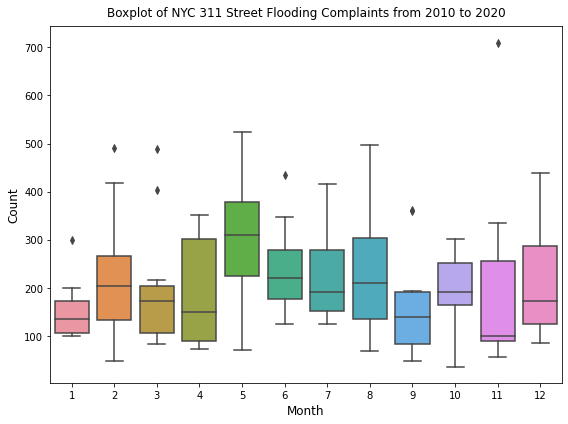

In [45]:
plt.figure(figsize=(8, 6))

sns.boxplot(data=seasonality_month,
            x='month',
            y='count')

plt.title('Boxplot of NYC 311 Street Flooding Complaints from 2010 to 2020', 
          fontsize=12,
          pad=10)

plt.xlabel('Month', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout()
plt.savefig('figures/timeseries_11.png', bbox_inches='tight')

In [46]:
df['quarter'] = df['created_date'].dt.quarter

seasonality_quarter = (
    df
    .groupby(by=['year_month_day'])['unique_key']
    .count()
    .rename(index="count")
    .resample('QS').sum()
    .reset_index()
)

seasonality_quarter.head()

,year_month_day,count
0,2010-01-01,784
1,2010-04-01,485
2,2010-07-01,683
3,2010-10-01,579
4,2011-01-01,548


In [47]:
seasonality_quarter['quarter'] = seasonality_quarter['year_month_day'].dt.quarter

seasonality_quarter.head(10)

,year_month_day,count,quarter
0,2010-01-01,784,1
1,2010-04-01,485,2
2,2010-07-01,683,3
3,2010-10-01,579,4
4,2011-01-01,548,1
5,2011-04-01,682,2
6,2011-07-01,1002,3
7,2011-10-01,409,4
8,2012-01-01,237,1
9,2012-04-01,795,2


In [48]:
seasonality_quarter[['quarter']].describe()

,quarter
count,44.00000
mean,2.50000
std,1.13096
min,1.00000
25%,1.75000
50%,2.50000
75%,3.25000
max,4.00000


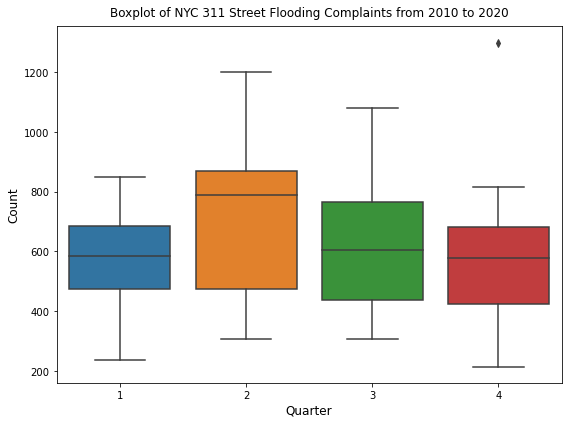

In [49]:
plt.figure(figsize=(8, 6))

sns.boxplot(data=seasonality_quarter,
            x='quarter',
            y='count')

plt.title('Boxplot of NYC 311 Street Flooding Complaints from 2010 to 2020', 
          fontsize=12,
          pad=10)

plt.xlabel('Quarter', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout()
plt.savefig('figures/timeseries_12.png', bbox_inches='tight')

In [50]:
df['week_of_year'] = df['created_date'].dt.isocalendar().week

seasonality_week = (
    df
    .groupby(by=['year_month_day'])['unique_key']
    .count()
    .rename(index="count")
    .reset_index()
    .set_index('year_month_day')
    .resample('W').sum()
)

seasonality_week.head()

,count
year_month_day,
2010-01-03,3
2010-01-10,11
2010-01-17,8
2010-01-24,13
2010-01-31,73


In [51]:
seasonality_week = seasonality_week.reset_index()
seasonality_week['week_of_year'] = seasonality_week['year_month_day'].dt.isocalendar().week

seasonality_week.head()

,year_month_day,count,week_of_year
0,2010-01-03,3,53
1,2010-01-10,11,1
2,2010-01-17,8,2
3,2010-01-24,13,3
4,2010-01-31,73,4


In [52]:
seasonality_week[['week_of_year']].describe()

,week_of_year
count,575.000000
mean,26.638261
std,15.103520
min,1.000000
25%,14.000000
50%,27.000000
75%,40.000000
max,53.000000


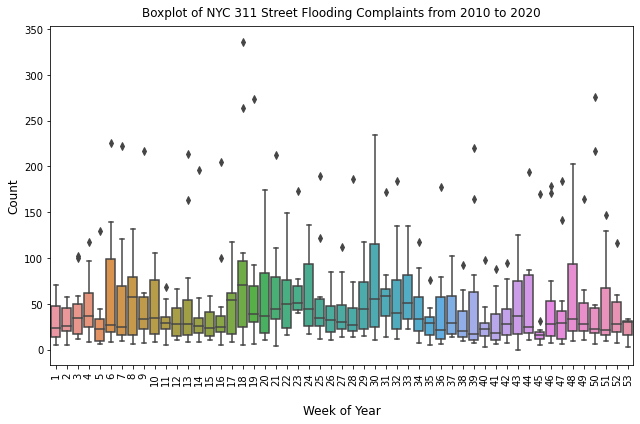

In [53]:
plt.figure(figsize=(9, 6))

sns.boxplot(data=seasonality_week,
            x='week_of_year',
            y='count')

plt.title('Boxplot of NYC 311 Street Flooding Complaints from 2010 to 2020', 
          fontsize=12,
          pad=10)
plt.xlabel('\nWeek of Year', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=90)

plt.tight_layout()
plt.savefig('figures/timeseries_13.png', bbox_inches='tight')

In [54]:
df['day'] = df['created_date'].dt.day 

seasonality_day = (
    df
    .groupby(by=['year_month_day'])['unique_key']
    .count()
    .rename(index="count")
    .reset_index()
    .set_index('year_month_day')
    .resample('d')
    .sum()
)

seasonality_day.head()

,count
year_month_day,
2010-01-02,3
2010-01-03,0
2010-01-04,1
2010-01-05,1
2010-01-06,4


In [55]:
seasonality_day = seasonality_day.reset_index()
seasonality_day['day'] = seasonality_day['year_month_day'].dt.day

seasonality_day.head()

,year_month_day,count,day
0,2010-01-02,3,2
1,2010-01-03,0,3
2,2010-01-04,1,4
3,2010-01-05,1,5
4,2010-01-06,4,6


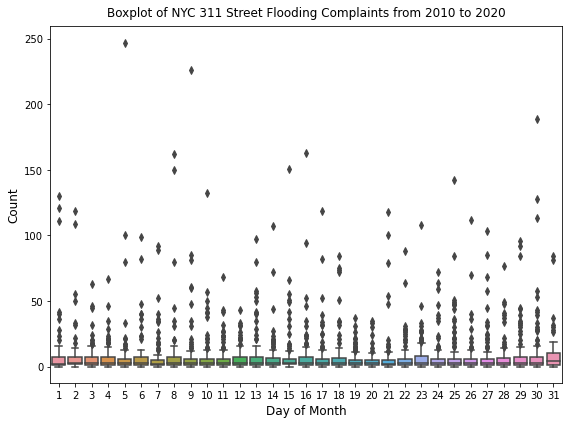

In [56]:
plt.figure(figsize=(8, 6))

sns.boxplot(data=seasonality_day,
            x='day',
            y='count')

plt.title('Boxplot of NYC 311 Street Flooding Complaints from 2010 to 2020', 
          fontsize=12,
          pad=10)
plt.xlabel('Day of Month', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.tight_layout()
plt.savefig('figures/timeseries_14.png', bbox_inches='tight')

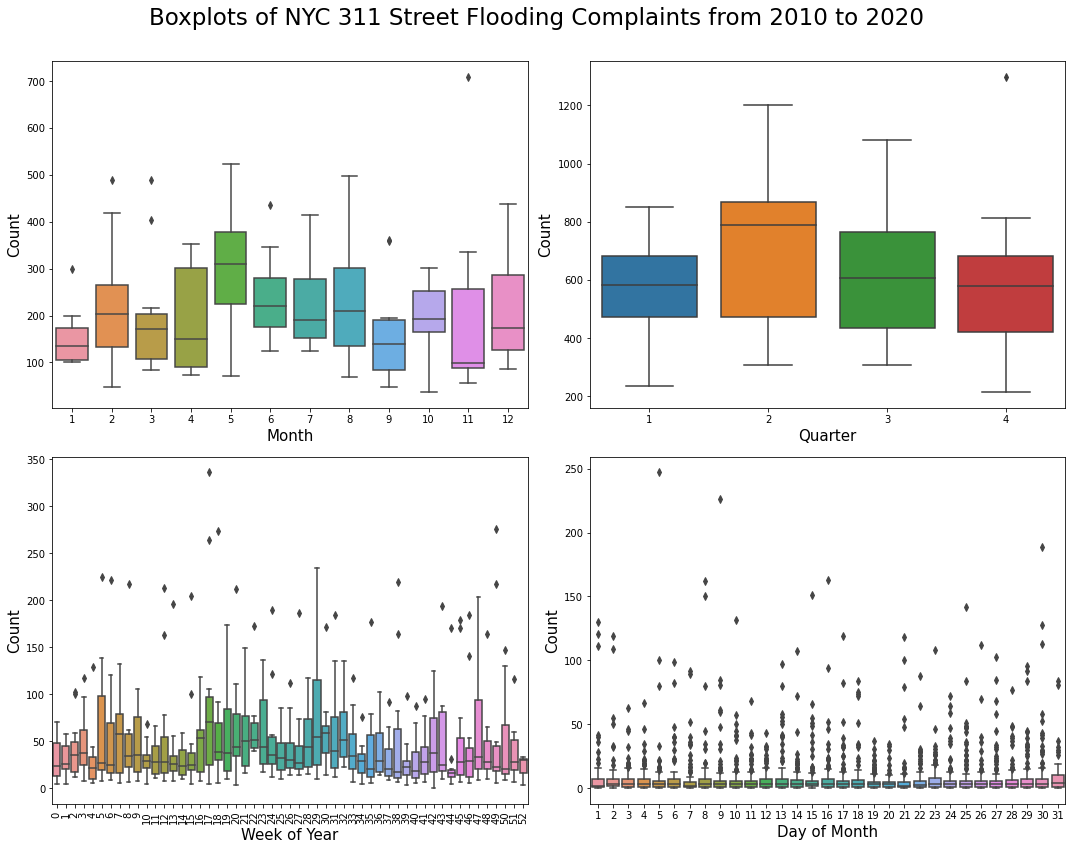

In [57]:
fig, axs = plt.subplots(2, 2, 
                        sharey=False, 
                        figsize=(15, 12))

sns.boxplot(data=seasonality_month,
            x='month',
            y='count',
            ax=axs[0,0])
axs[0,0].set_xlabel('Month', fontsize=15)

sns.boxplot(data=seasonality_quarter,
            x='quarter',
            y='count',
            ax=axs[0,1])
axs[0,1].set_xlabel('Quarter', fontsize=15)

sns.boxplot(data=seasonality_week,
            x='week_of_year',
            y='count',
            ax=axs[1,0])
axs[1,0].set_xlabel('Week of Year', fontsize=15)
axs[1,0].set_xticklabels(axs[1,0].get_xticks(), rotation=90)

sns.boxplot(data=seasonality_day,
            x='day',
            y='count',
            ax=axs[1,1])
axs[1,1].set_xlabel('Day of Month', fontsize=15)

for ax in axs.flat:
    ax.set_ylabel('Count', fontsize=15)

fig.suptitle('Boxplots of NYC 311 Street Flooding Complaints from 2010 to 2020\n', fontsize=23)

plt.tight_layout()
plt.savefig('figures/timeseries_15.png', bbox_inches='tight')

# 6.5 Resampling for Frequency Average

In [58]:
flooding_311_daily = (
    df
    .groupby(by='year_month_day')['unique_key']
    .count()
    .resample('D')
    .sum()
    .rename(index="count")
)

flooding_311_daily.head(10)

year_month_day
2010-01-02    3
2010-01-03    0
2010-01-04    1
2010-01-05    1
2010-01-06    4
2010-01-07    3
2010-01-08    1
2010-01-09    1
2010-01-10    0
2010-01-11    0
Freq: D, Name: count, dtype: int64

In [59]:
weekly_mean = flooding_311_daily.resample('W').mean()
monthly_mean = flooding_311_daily.resample('MS').mean()
yearly_mean = flooding_311_daily.resample('YS').mean()

In [60]:
weekly_mean.head()

year_month_day
2010-01-03     1.500000
2010-01-10     1.571429
2010-01-17     1.142857
2010-01-24     1.857143
2010-01-31    10.428571
Freq: W-SUN, Name: count, dtype: float64

In [61]:
monthly_mean.head()

year_month_day
2010-01-01     3.600000
2010-02-01     6.678571
2010-03-01    15.774194
2010-04-01     4.966667
2010-05-01     6.548387
Freq: MS, Name: count, dtype: float64

In [62]:
yearly_mean.head()

year_month_day
2010-01-01    6.953297
2011-01-01    7.235616
2012-01-01    6.019126
2013-01-01    4.558904
2014-01-01    6.843836
Freq: AS-JAN, Name: count, dtype: float64

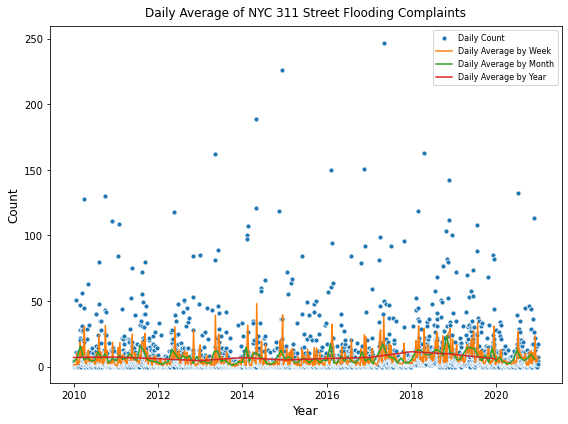

In [63]:
plt.figure(figsize=(8, 6))

sns.lineplot(data=flooding_311_daily, marker='.', markersize=10, linewidth=0, label='Daily Count')
sns.lineplot(data=weekly_mean, label='Daily Average by Week')
sns.lineplot(data=monthly_mean, label='Daily Average by Month')
sns.lineplot(data=yearly_mean, label='Daily Average by Year')

plt.title('Daily Average of NYC 311 Street Flooding Complaints', 
          fontsize=12,
          pad=10)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(fontsize=8)
plt.tight_layout()
plt.savefig('figures/timeseries_16.png', bbox_inches='tight')

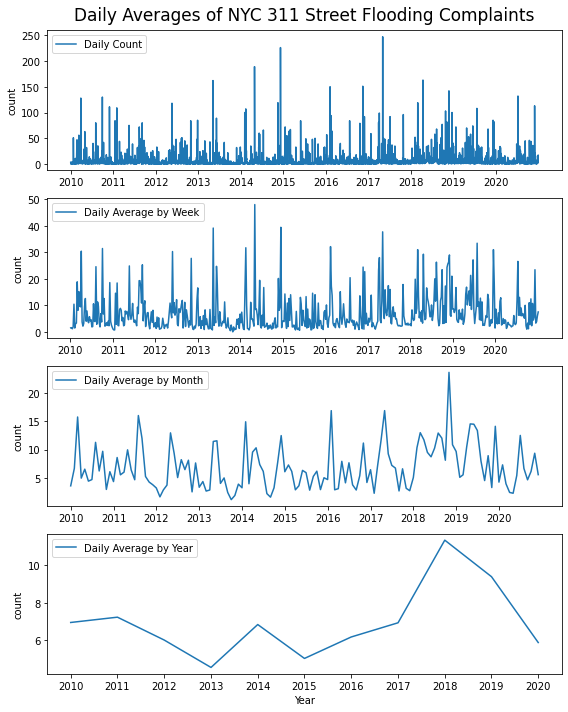

In [64]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharey=False, figsize=(8,10))

years = mdates.YearLocator() # every year

sns.lineplot(data=flooding_311_daily, 
             label='Daily Count', 
             ax=ax1)
sns.lineplot(data=weekly_mean, 
             label='Daily Average by Week', 
             ax=ax2)
sns.lineplot(data=monthly_mean, 
             label='Daily Average by Month', 
             ax=ax3)
sns.lineplot(data=yearly_mean, 
             label='Daily Average by Year', 
             ax=ax4)

ax1.set_title('Daily Averages of NYC 311 Street Flooding Complaints', 
              fontsize=17, 
              pad=10)

lst = [ax1, ax2, ax3, ax4]
for i in range(len(lst)):
    lst[i].set_xlabel('')
    lst[i].legend(loc=2, fontsize=10)
    lst[i].xaxis.set_major_locator(years)
    
plt.xlabel('Year')    
    
plt.tight_layout()
plt.savefig('figures/timeseries_17.png', bbox_inches='tight')

# 6.6 Rolling Averages

In [65]:
flooding_311_daily = (
    df
    .groupby(by='year_month_day')['unique_key']
    .count()
    .resample('D')
    .sum()
    .rename(index="count")
)

flooding_311_daily.head(10)

year_month_day
2010-01-02    3
2010-01-03    0
2010-01-04    1
2010-01-05    1
2010-01-06    4
2010-01-07    3
2010-01-08    1
2010-01-09    1
2010-01-10    0
2010-01-11    0
Freq: D, Name: count, dtype: int64

In [66]:
(flooding_311_daily
 .rolling(7)
 .mean()
 .head(10)
)

year_month_day
2010-01-02         NaN
2010-01-03         NaN
2010-01-04         NaN
2010-01-05         NaN
2010-01-06         NaN
2010-01-07         NaN
2010-01-08    1.857143
2010-01-09    1.571429
2010-01-10    1.571429
2010-01-11    1.428571
Freq: D, Name: count, dtype: float64

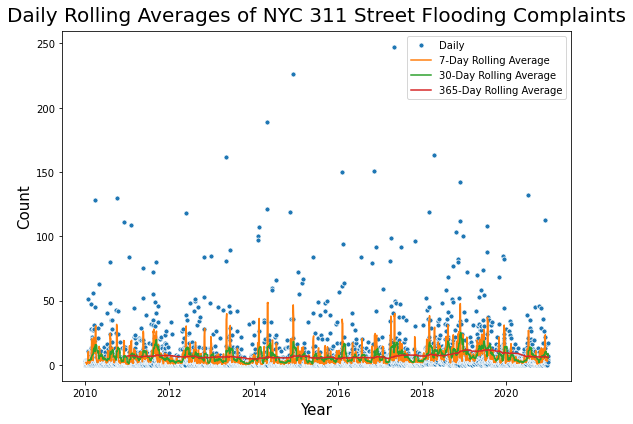

In [67]:
plt.figure(figsize=(8, 6))

sns.lineplot(data=flooding_311_daily, marker='.', markersize=10, linewidth=0, label='Daily')
sns.lineplot(data=flooding_311_daily.rolling(7).mean(), label='7-Day Rolling Average')
sns.lineplot(data=flooding_311_daily.rolling(30).mean(), label='30-Day Rolling Average')
sns.lineplot(data=flooding_311_daily.rolling(365).mean(), label='365-Day Rolling Average')

plt.title('Daily Rolling Averages of NYC 311 Street Flooding Complaints', 
          fontsize=20,
          pad=10)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.tight_layout()
plt.savefig('figures/timeseries_18.png', bbox_inches='tight')

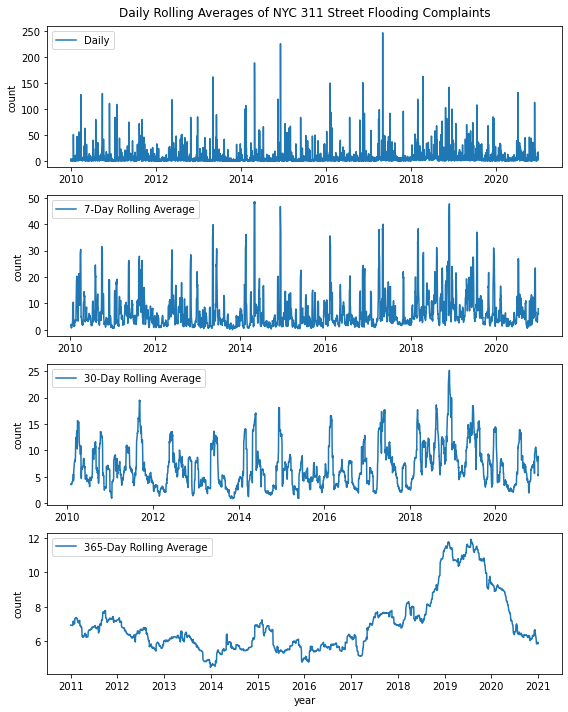

In [68]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharey=False, figsize=(8,10))

sns.lineplot(data=flooding_311_daily, 
             label='Daily', 
             ax=ax1)
sns.lineplot(data=flooding_311_daily.rolling(7).mean(), 
             label='7-Day Rolling Average', 
             ax=ax2)
sns.lineplot(data=flooding_311_daily.rolling(30).mean(), 
             label='30-Day Rolling Average', 
             ax=ax3)
sns.lineplot(data=flooding_311_daily.rolling(365).mean(), 
             label='365-Day Rolling Average', 
             ax=ax4)

ax1.set_title('Daily Rolling Averages of NYC 311 Street Flooding Complaints', 
              fontsize=12, 
              pad=10)

lst = [ax1, ax2, ax3, ax4]
for i in range(len(lst)):
    lst[i].set_xlabel('')  
    lst[i].legend(loc=2, fontsize=10)
    
plt.xlabel('year')    
    
fig.tight_layout()    
plt.savefig('figures/timeseries_19.png', bbox_inches='tight')

## 6.7 Additional Time Series Analysis

In [69]:
df.head()

,unique_key,created_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,cross_street_1,...,resolution_description,resolution_action_updated_date,year,year_month_day,year_month,year_month_week,month,quarter,week_of_year,day
0,48542220,2020-12-31 15:41:00,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11420.0,117-17 135 STREET,135 STREET,FOCH BLVD,...,Please call 311 for further information. If yo...,2021-01-01T00:20:00.000,2020,2020-12-31,2020-12-01,2021-01-03,12,4,53,31
1,48536430,2020-12-31 14:49:00,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11357.0,20-24 150 STREET,150 STREET,20 AVE,...,The Department of Environment Protection inspe...,2021-01-04T10:15:00.000,2020,2020-12-31,2020-12-01,2021-01-03,12,4,53,31
2,48539361,2020-12-31 14:03:00,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11228.0,7223 8 AVENUE,8 AVENUE,72 ST,...,The Department of Environmental Protection has...,2021-01-02T11:25:00.000,2020,2020-12-31,2020-12-01,2021-01-03,12,4,53,31
3,48543132,2020-12-31 13:48:00,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10032.0,NaN,NaN,NaN,...,Please call 311 for further information. If yo...,2020-12-31T14:50:00.000,2020,2020-12-31,2020-12-01,2021-01-03,12,4,53,31
4,48536441,2020-12-31 13:10:00,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11234.0,3123 FILLMORE AVENUE,FILLMORE AVENUE,E 31 ST,...,The Department of Environmental Protection ins...,2021-01-03T10:45:00.000,2020,2020-12-31,2020-12-01,2021-01-03,12,4,53,31


In [70]:
df['day_name'] = df['created_date'].dt.day_name()

df.iloc[:, -5:].head()

,month,quarter,week_of_year,day,day_name
0,12,4,53,31,Thursday
1,12,4,53,31,Thursday
2,12,4,53,31,Thursday
3,12,4,53,31,Thursday
4,12,4,53,31,Thursday


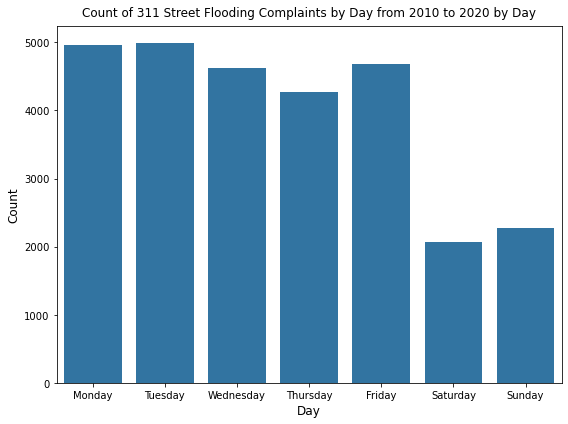

In [71]:
plt.figure(figsize=(8, 6))

order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

sns.countplot(x=df['day_name'],
              color='#1f77b4',
              order=order)

plt.title('Count of 311 Street Flooding Complaints by Day from 2010 to 2020 by Day', 
          fontsize=12,
          pad=10)
plt.xlabel('Day', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout()

In [72]:
df['hour'] = df['created_date'].dt.hour

df.iloc[:, -5:].head()

,quarter,week_of_year,day,day_name,hour
0,4,53,31,Thursday,15
1,4,53,31,Thursday,14
2,4,53,31,Thursday,14
3,4,53,31,Thursday,13
4,4,53,31,Thursday,13


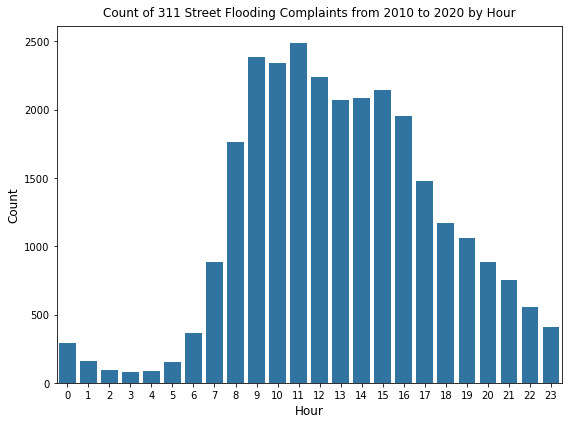

In [73]:
plt.figure(figsize=(8, 6))

sns.countplot(x=df['hour'],
              color='#1f77b4')

plt.title('Count of 311 Street Flooding Complaints from 2010 to 2020 by Hour', 
          fontsize=12,
          pad=10)
plt.xlabel('Hour', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout()

In [74]:
df['time'] = df['created_date'].dt.time

df.iloc[:, -5:].head()

,week_of_year,day,day_name,hour,time
0,53,31,Thursday,15,15:41:00
1,53,31,Thursday,14,14:49:00
2,53,31,Thursday,14,14:03:00
3,53,31,Thursday,13,13:48:00
4,53,31,Thursday,13,13:10:00


In [75]:
flooding_time = (
    df
    .groupby(by='time')['unique_key']
    .count()
    .rename(index="count")
    .reset_index()
)

flooding_time.head()

,time,count
0,00:00:00,73
1,00:01:00,6
2,00:02:00,6
3,00:03:00,4
4,00:04:00,6


In [76]:
flooding_time.time = pd.to_datetime(flooding_time.time, format='%H:%M:%S')
flooding_time.head()

,time,count
0,1900-01-01 00:00:00,73
1,1900-01-01 00:01:00,6
2,1900-01-01 00:02:00,6
3,1900-01-01 00:03:00,4
4,1900-01-01 00:04:00,6


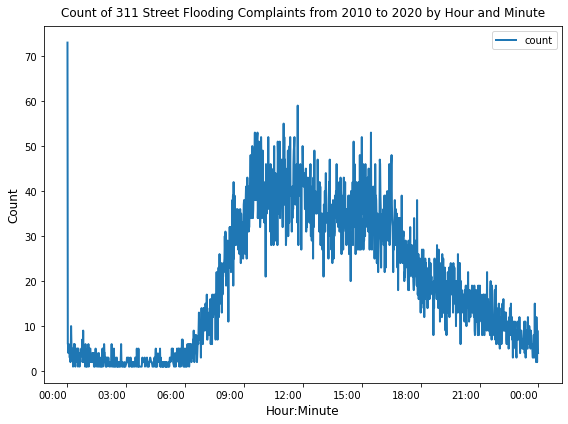

In [77]:
fig, ax = plt.subplots(figsize=(8, 6))

myformat = matplotlib.dates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myformat)

flooding_time.plot(x='time',
                   y='count',
                   ax=ax, 
                   rot=0,
                   color='#1f77b4', 
                   linewidth=2)

plt.title('Count of 311 Street Flooding Complaints from 2010 to 2020 by Hour and Minute', 
          fontsize=12,
          pad=10)
plt.xlabel('Hour:Minute', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout()

In [78]:
(flooding_time
 .sort_values(by='count', ascending=False)
 .head(10)
)

,time,count
0,1900-01-01 00:00:00,73
648,1900-01-01 11:44:00,59
605,1900-01-01 11:01:00,55
517,1900-01-01 09:33:00,53
525,1900-01-01 09:41:00,53
872,1900-01-01 15:28:00,53
625,1900-01-01 11:21:00,52
638,1900-01-01 11:34:00,52
844,1900-01-01 15:00:00,52
524,1900-01-01 09:40:00,52


In [79]:
flooding_time = (
    flooding_time
    .set_index('time')['count']
    .rolling(15)
    .mean()
)

flooding_time

time
1900-01-01 00:00:00         NaN
1900-01-01 00:01:00         NaN
1900-01-01 00:02:00         NaN
1900-01-01 00:03:00         NaN
1900-01-01 00:04:00         NaN
                         ...   
1900-01-01 23:55:00    6.266667
1900-01-01 23:56:00    6.000000
1900-01-01 23:57:00    6.333333
1900-01-01 23:58:00    6.466667
1900-01-01 23:59:00    6.400000
Name: count, Length: 1384, dtype: float64

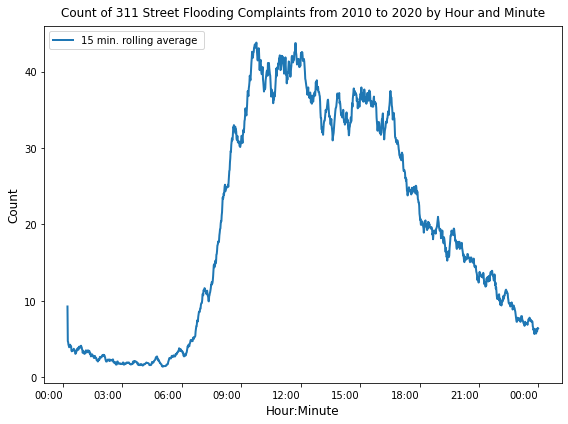

In [80]:
fig, ax = plt.subplots(figsize=(8, 6))

myformat = matplotlib.dates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myformat)

flooding_time.plot(y='count',
                   ax=ax, 
                   rot=0,
                   color='#1f77b4', 
                   linewidth=2,
                   label='15 min. rolling average ', 
                   legend=True)

plt.title('Count of 311 Street Flooding Complaints from 2010 to 2020 by Hour and Minute', 
          fontsize=12,
          pad=10)
plt.legend(loc=2, fontsize=10)
plt.xlabel('Hour:Minute', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout()

In [81]:
df['am_pm'] = df['created_date'].dt.strftime('%p')

df.head()

,unique_key,created_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,cross_street_1,...,year_month,year_month_week,month,quarter,week_of_year,day,day_name,hour,time,am_pm
0,48542220,2020-12-31 15:41:00,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11420.0,117-17 135 STREET,135 STREET,FOCH BLVD,...,2020-12-01,2021-01-03,12,4,53,31,Thursday,15,15:41:00,PM
1,48536430,2020-12-31 14:49:00,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11357.0,20-24 150 STREET,150 STREET,20 AVE,...,2020-12-01,2021-01-03,12,4,53,31,Thursday,14,14:49:00,PM
2,48539361,2020-12-31 14:03:00,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11228.0,7223 8 AVENUE,8 AVENUE,72 ST,...,2020-12-01,2021-01-03,12,4,53,31,Thursday,14,14:03:00,PM
3,48543132,2020-12-31 13:48:00,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10032.0,NaN,NaN,NaN,...,2020-12-01,2021-01-03,12,4,53,31,Thursday,13,13:48:00,PM
4,48536441,2020-12-31 13:10:00,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11234.0,3123 FILLMORE AVENUE,FILLMORE AVENUE,E 31 ST,...,2020-12-01,2021-01-03,12,4,53,31,Thursday,13,13:10:00,PM


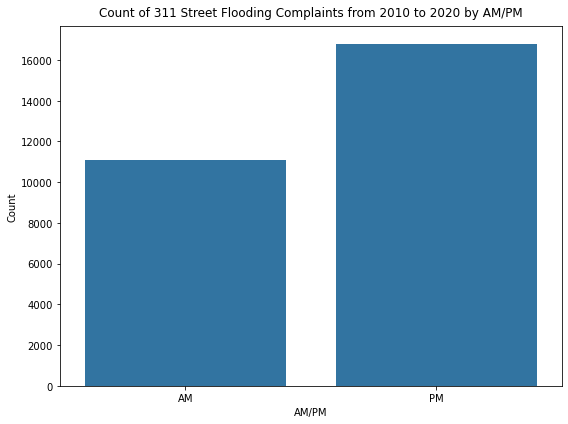

In [82]:
plt.figure(figsize=(8,6))

order = ['AM', 'PM']

sns.countplot(x=df['am_pm'],
              color='#1f77b4',
              order=order)

plt.title('Count of 311 Street Flooding Complaints from 2010 to 2020 by AM/PM', 
          fontsize=12,
          pad=10)
plt.xlabel('AM/PM', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.tight_layout()

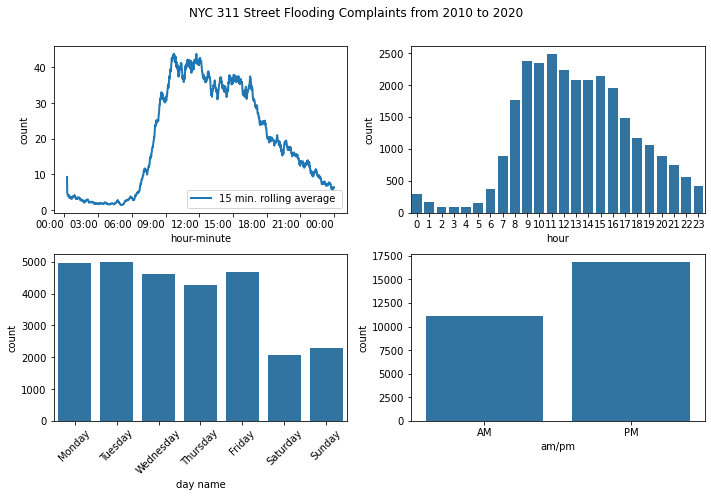

In [83]:
fig, axs = plt.subplots(2, 2, sharey=False, figsize=(10, 7))

myFmt = matplotlib.dates.DateFormatter('%H:%M')
axs[0,0].xaxis.set_major_formatter(myFmt)
flooding_time.plot(x='time',
                   y='count',
                   ax=axs[0,0], 
                   rot=0,
                   color='#1f77b4', 
                   linewidth=2,
                   legend=True,
                   label='15 min. rolling average ')
axs[0,0].set_ylabel('count') 
axs[0,0].set_xlabel('hour-minute')

sns.countplot(x=df['hour'],
              color='#1f77b4',
              ax=axs[0,1])

order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.countplot(x=df['day_name'],
              color='#1f77b4',
              order=order,
              ax=axs[1,0])
axs[1,0].set_xlabel('day name')
axs[1,0].set_xticklabels(axs[1,0].get_xticklabels(), rotation=45)

order = ['AM', 'PM']
sns.countplot(x=df['am_pm'],
              color='#1f77b4',
              order=order,
              ax=axs[1,1])
axs[1,1].set_xlabel('am/pm')

fig.suptitle('NYC 311 Street Flooding Complaints from 2010 to 2020\n', fontsize=12) 

plt.tight_layout()
plt.savefig('figures/timeseries_20.png', bbox_inches='tight')

# 7. Anomoly Detection

Count per Frequency Ranked

In [84]:
df.head()

,unique_key,created_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,cross_street_1,...,year_month,year_month_week,month,quarter,week_of_year,day,day_name,hour,time,am_pm
0,48542220,2020-12-31 15:41:00,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11420.0,117-17 135 STREET,135 STREET,FOCH BLVD,...,2020-12-01,2021-01-03,12,4,53,31,Thursday,15,15:41:00,PM
1,48536430,2020-12-31 14:49:00,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11357.0,20-24 150 STREET,150 STREET,20 AVE,...,2020-12-01,2021-01-03,12,4,53,31,Thursday,14,14:49:00,PM
2,48539361,2020-12-31 14:03:00,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11228.0,7223 8 AVENUE,8 AVENUE,72 ST,...,2020-12-01,2021-01-03,12,4,53,31,Thursday,14,14:03:00,PM
3,48543132,2020-12-31 13:48:00,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10032.0,NaN,NaN,NaN,...,2020-12-01,2021-01-03,12,4,53,31,Thursday,13,13:48:00,PM
4,48536441,2020-12-31 13:10:00,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11234.0,3123 FILLMORE AVENUE,FILLMORE AVENUE,E 31 ST,...,2020-12-01,2021-01-03,12,4,53,31,Thursday,13,13:10:00,PM


In [85]:
daily = (
    df
    .groupby(by='year_month_day')['unique_key']
    .count()
    .resample('D')
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
    .rename(columns={"unique_key": "count"})
)

daily['date_formatted'] = daily['year_month_day'].dt.strftime('%Y-%m-%d')

daily.head(10)

,year_month_day,count,date_formatted
0,2017-05-05,247,2017-05-05
1,2014-12-09,226,2014-12-09
2,2014-04-30,189,2014-04-30
3,2018-04-16,163,2018-04-16
4,2013-05-08,162,2013-05-08
5,2016-11-15,151,2016-11-15
6,2016-02-08,150,2016-02-08
7,2018-11-25,142,2018-11-25
8,2020-07-10,132,2020-07-10
9,2010-10-01,130,2010-10-01


In [86]:
weekly = (
    df
    .groupby(by='year_month_day')['unique_key']
    .count()
    .resample('W')
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
    .rename(columns={"unique_key": "count"})
)

weekly['date_formatted'] = weekly['year_month_day'].dt.strftime('%Y-%m-%d')

weekly.head(10)

,year_month_day,count,date_formatted
0,2014-05-04,336,2014-05-04
1,2014-12-14,276,2014-12-14
2,2013-05-12,274,2013-05-12
3,2017-05-07,264,2017-05-07
4,2019-07-28,234,2019-07-28
5,2016-02-14,225,2016-02-14
6,2014-02-16,222,2014-02-16
7,2010-10-03,220,2010-10-03
8,2018-03-04,217,2018-03-04
9,2019-12-15,217,2019-12-15


In [87]:
monthly = (
    df
    .groupby(by='year_month_day')['unique_key']
    .count()
    .resample('MS')
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
    .rename(columns={"unique_key": "count"})
)

monthly['date_formatted'] = monthly['year_month_day'].dt.strftime('%Y-%b')

monthly.head()

,year_month_day,count,date_formatted
0,2018-11-01,710,2018-Nov
1,2017-05-01,524,2017-May
2,2011-08-01,497,2011-Aug
3,2016-02-01,490,2016-Feb
4,2010-03-01,489,2010-Mar


In [88]:
yearly = (
    df
    .groupby(by='year_month_day')['unique_key']
    .count()
    .resample('YS')
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
    .rename(columns={"unique_key": "count"})
)

yearly['date_formatted'] = yearly['year_month_day'].dt.strftime('%Y')

yearly

,year_month_day,count,date_formatted
0,2018-01-01,4138,2018
1,2019-01-01,3428,2019
2,2011-01-01,2641,2011
3,2017-01-01,2532,2017
4,2010-01-01,2531,2010
5,2014-01-01,2498,2014
6,2016-01-01,2262,2016
7,2012-01-01,2203,2012
8,2020-01-01,2154,2020
9,2015-01-01,1839,2015


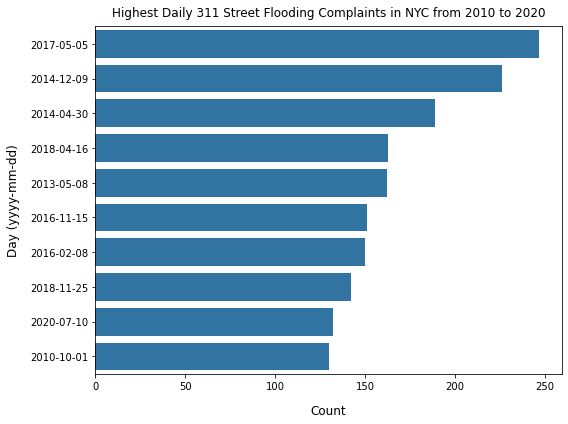

In [89]:
plt.figure(figsize=(8,6))

sns.barplot(data=daily,
            y='date_formatted',
            x='count',
            color='#1f77b4')

plt.title('Highest Daily 311 Street Flooding Complaints in NYC from 2010 to 2020', 
          fontsize=12,
          pad=10)
plt.xlabel('Count', fontsize=12, labelpad=13)
plt.ylabel('Day (yyyy-mm-dd)', fontsize=12, labelpad=10)
plt.tight_layout()

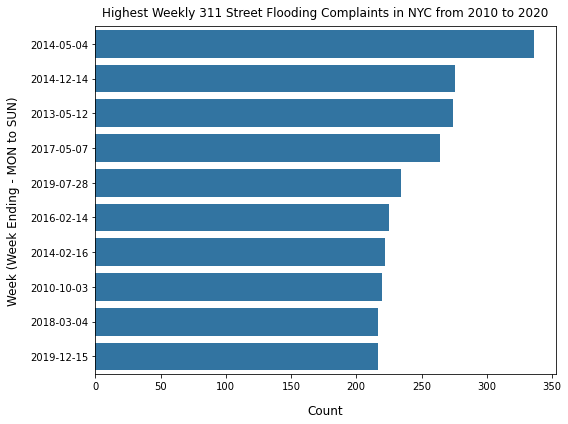

In [90]:
plt.figure(figsize=(8,6))

sns.barplot(data=weekly,
            y='date_formatted',
            x='count',
            color='#1f77b4')

plt.title('Highest Weekly 311 Street Flooding Complaints in NYC from 2010 to 2020', 
          fontsize=12,
          pad=10)
plt.xlabel('Count', fontsize=12, labelpad=13)
plt.ylabel('Week (Week Ending - MON to SUN)', fontsize=12, labelpad=10)
plt.tight_layout()

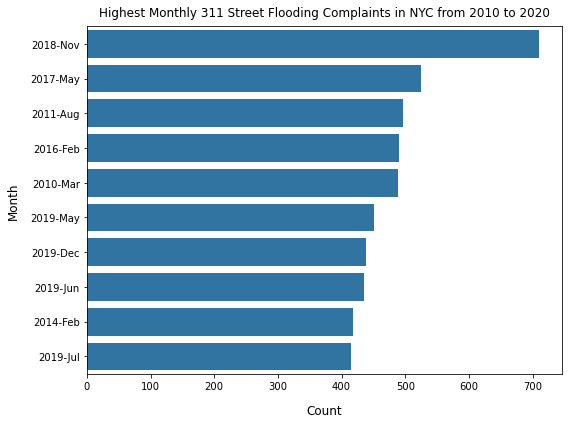

In [91]:
plt.figure(figsize=(8,6))

sns.barplot(data=monthly,
            y='date_formatted',
            x='count',
            color='#1f77b4')

plt.title('Highest Monthly 311 Street Flooding Complaints in NYC from 2010 to 2020', 
          fontsize=12,
          pad=10)
plt.xlabel('Count', fontsize=12, labelpad=13)
plt.ylabel('Month', fontsize=12, labelpad=10)
plt.tight_layout()

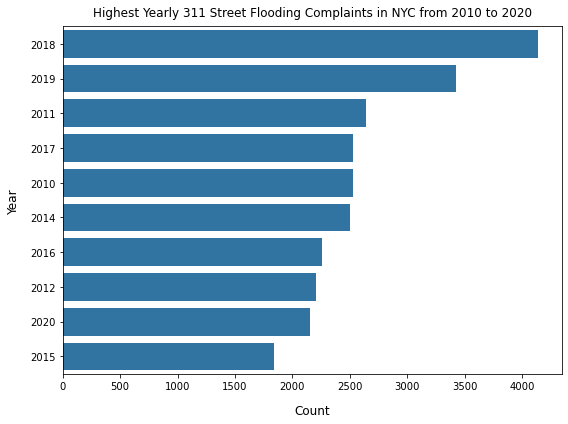

In [92]:
plt.figure(figsize=(8,6))

sns.barplot(data=yearly,
            y='date_formatted',
            x='count',
            color='#1f77b4')

plt.title('Highest Yearly 311 Street Flooding Complaints in NYC from 2010 to 2020', 
          fontsize=12,
          pad=10)
plt.xlabel('Count', fontsize=12, labelpad=13)
plt.ylabel('Year', fontsize=12, labelpad=10)
plt.tight_layout()

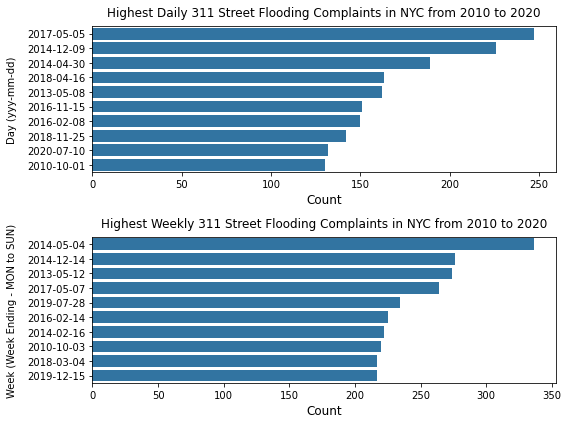

In [93]:
fig, axs = plt.subplots(2, 1, sharey=False, figsize=(8, 6))

# first plot
sns.barplot(data=daily,
            y='date_formatted',
            x='count',
            color='#1f77b4',
            ax=axs[0])

axs[0].set_title('Highest Daily 311 Street Flooding Complaints in NYC from 2010 to 2020', 
                  fontsize=12,
                  pad=10)
axs[0].set_xlabel('Count', fontsize=12)
axs[0].set_ylabel('Day (yyy-mm-dd)', fontsize=10, labelpad=10)

# second plot
sns.barplot(data=weekly,
            y='date_formatted',
            x='count',
            color='#1f77b4',
            ax=axs[1])

axs[1].set_title('Highest Weekly 311 Street Flooding Complaints in NYC from 2010 to 2020', 
                  fontsize=12,
                  pad=10)
axs[1].set_xlabel('Count', fontsize=12)
axs[1].set_ylabel('Week (Week Ending - MON to SUN)', fontsize=10, labelpad=10)

fig.tight_layout()

# 8. Manually Formatting Date Tick Labels

In [94]:
daily = (
    df.groupby(by='year_month_day')['unique_key'].count()
    .resample('D')
    .sum()
    .rename(index="count")
)

daily.head(10)

year_month_day
2010-01-02    3
2010-01-03    0
2010-01-04    1
2010-01-05    1
2010-01-06    4
2010-01-07    3
2010-01-08    1
2010-01-09    1
2010-01-10    0
2010-01-11    0
Freq: D, Name: count, dtype: int64

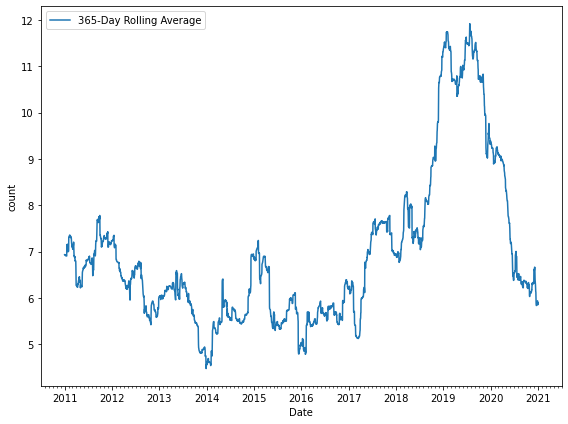

In [95]:
fig, ax = plt.subplots(figsize=(8,6))

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

sns.lineplot(data=daily.rolling(365).mean(), 
             label='365-Day Rolling Average', 
             ax=ax)

plt.legend(loc=2)
plt.xlabel('Date')
plt.tight_layout()

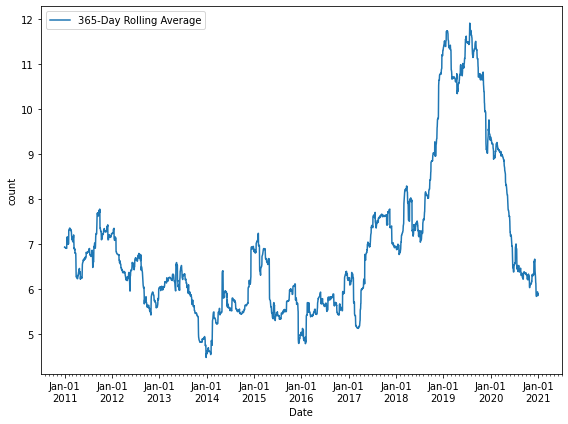

In [96]:
fig, ax = plt.subplots(figsize=(8,6))

years = mdates.YearLocator() # every year
months = mdates.MonthLocator() # every month
years_fmt = mdates.DateFormatter('%b-%d\n%Y')

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

sns.lineplot(data=daily.rolling(365).mean(), 
             label='365-Day Rolling Average', 
             ax=ax)

plt.legend(loc=2)
plt.xlabel('Date')
plt.tight_layout()

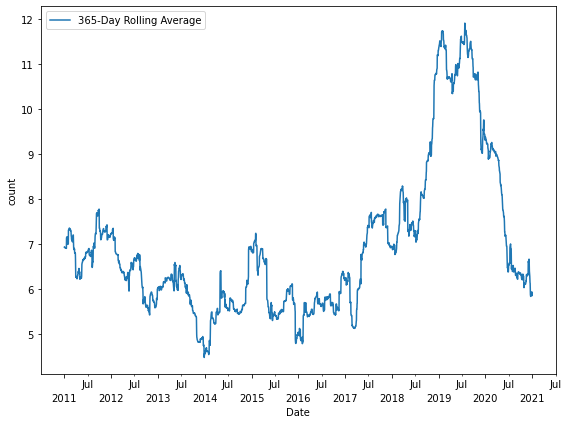

In [97]:
fig, ax = plt.subplots(figsize=(8,6))

years = mdates.YearLocator() # every year
months = mdates.MonthLocator(7) # display on May (5)
monthsFmt = mdates.DateFormatter('%b') 
yearsFmt = mdates.DateFormatter('\n%Y')

ax.xaxis.set_minor_locator(months)
ax.xaxis.set_minor_formatter(monthsFmt)
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)

sns.lineplot(data=daily.rolling(365).mean(), 
             label='365-Day Rolling Average', 
             ax=ax)

plt.legend(loc=2)
plt.xlabel('Date')
plt.tight_layout()

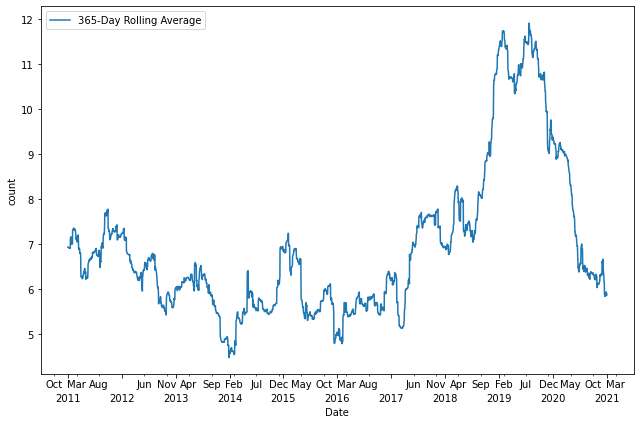

In [98]:
fig, ax = plt.subplots(figsize=(9,6))

years = mdates.YearLocator() # every year
months = mdates.MonthLocator(interval=5) # every 5 months
monthsFmt = mdates.DateFormatter('%b') 
yearsFmt = mdates.DateFormatter('\n%Y')

ax.xaxis.set_minor_locator(months)
ax.xaxis.set_minor_formatter(monthsFmt)
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)

sns.lineplot(data=daily.rolling(365).mean(), 
             label='365-Day Rolling Average', 
             ax=ax)

plt.legend(loc=2)
plt.xlabel('Date')
plt.tight_layout()